In [226]:
import cv2 as cv
import matplotlib.pyplot as plt
import os

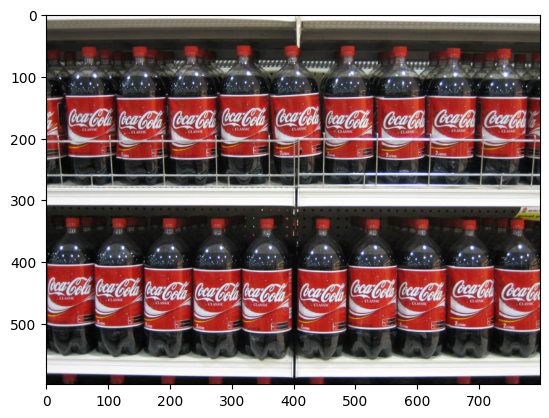

In [227]:
coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
plt.imshow(coca_multi)

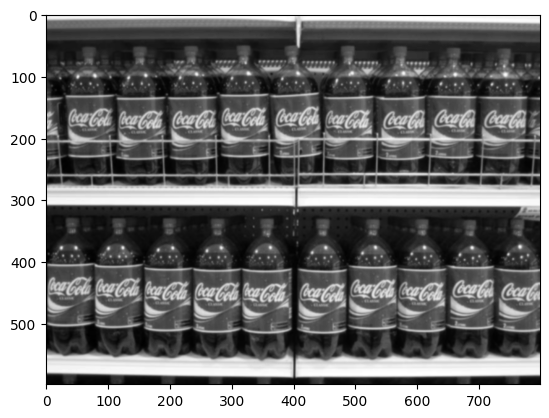

In [228]:
def filter_closed_loops(gray):
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary)
    for contour in contours:
        if cv.arcLength(contour, True) > 100:
            cv.drawContours(mask, [contour], -1, 255, thickness=cv.FILLED)
    filtered_image = cv.bitwise_and(binary, mask)
    return filtered_image
    
def preprocess(image):
    # recommendeded ratios for canny are: 2:1 and 3:1,
    value = 115
    ratio = 2 
    threshold_1, threshold_2 = value, value*ratio
    # if len(image.shape) == 3:
    grayscale = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if len(image.shape) == 3 else image.copy()
    # grayscale = cv.equalizeHist(grayscale)
    blurred = cv.GaussianBlur(grayscale, (5, 5), 0)
    # sharpened = um(blurred)
    canny_edges = cv.Canny(blurred, threshold_1, threshold_2)
    canny_edges_after_blur = cv.Canny(blurred,threshold_1, threshold_2)
    # filtered = filter_closed_loops(canny_edges_after_blur)
    # return grayscale, blurred, sharpened, canny_edges, canny_edges_after_blur, filtered
    return grayscale, blurred, canny_edges, canny_edges_after_blur

# from skimage.filters import unsharp_mask
# def um(img):
#     um_img = unsharp_mask(img, radius=10, amount=0.5)
#     sharpened = cv.normalize(um_img, None, 0, 255,cv.NORM_MINMAX, dtype=cv.CV_8U)
#     return sharpened

def preprocess_(image):
    return preprocess(image)[3]

# grayscale, blurred, sharpened, canny_edges, canny_edges_after_blur, filtered = preprocess(coca_multi)
grayscale, blurred, canny_edges, canny_edges_after_blur = preprocess(coca_multi)
plt.imshow(blurred, cmap='gray')

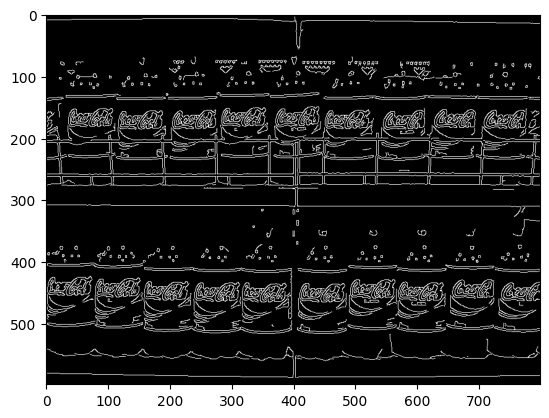

In [229]:
plt.imshow(canny_edges, cmap='gray')

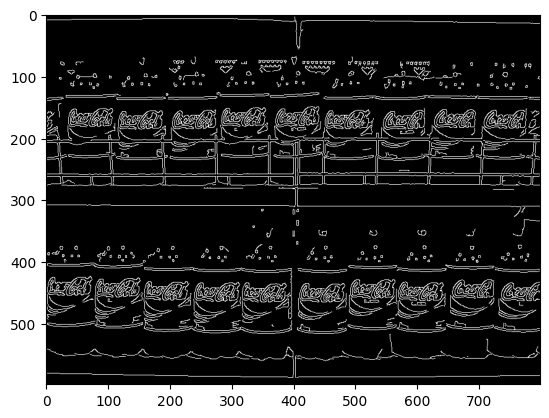

In [230]:
plt.imshow(canny_edges_after_blur, cmap='gray')

2.9166666666666665

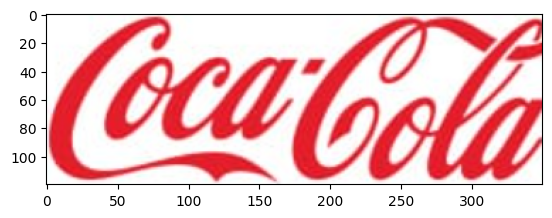

In [231]:
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
template_reduced = template[30:-25, 10:-40]
plt.imshow(template_reduced)
aspect_ratio = template_reduced.shape[1]/template_reduced.shape[0]
aspect_ratio

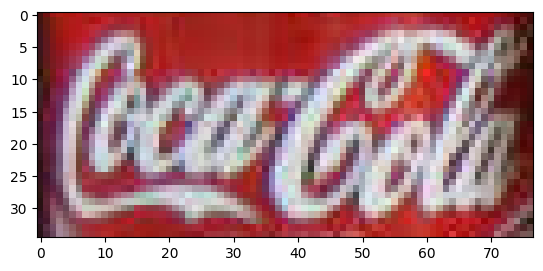

In [232]:
some_other = coca_multi.copy()
some_other = some_other[150:185,33:110,:]
plt.imshow(some_other)

In [233]:
some_other.shape

(35, 77, 3)

In [234]:
aspect_ratio = some_other.shape[1]/some_other.shape[0]
aspect_ratio

2.2

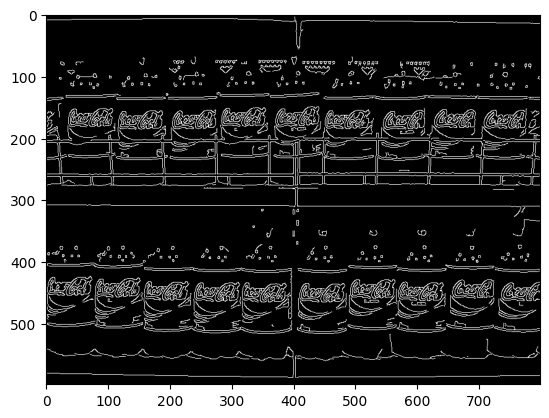

In [235]:
import imutils
import numpy as np
def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def detect_logo(image_rgb, method, threshold=0.80):
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    # template_reduced = template[30:-25, 10:-15]
    template_reduced = template[30:-25, 10:-40]
    
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    tW, tH = gray.shape[::-1]
    found = {}    
    min_result = 1e20
    max_result = -1e20
    all_results = np.array([], dtype=np.float32)

    edged = preprocess_(image_rgb)
    plt.imshow(edged, cmap='gray')
    
    for scale in np.linspace(0.2,2,40):
        resized = imutils.resize(template_reduced, width=int(template_reduced.shape[1] * scale))
        for scale_w in np.linspace(0.5,1.0,6):
            h,w,_ = resized.shape
            new_resized = cv.resize(resized, (int(w*scale_w),h))
            if new_resized.shape[0] <= 0.05 * image_rgb.shape[0] or new_resized.shape[1] <= 0.05*image_rgb.shape[1]:
                continue
            try:
                result = cv.matchTemplate(edged, preprocess_(new_resized), method)
                found[f'{new_resized.shape[0]},{new_resized.shape[1]}'] = result
                all_results = np.concatenate((all_results, result.flatten()))
                min_result = min(min_result, np.min(result))
                max_result = max(max_result, np.max(result))
            except Exception as e:
                pass

    # print(max_result)
    # print(min_result)
    bbox = []
    scores = []
    for scale_hash, result_scale in found.items():
        normalized_data = normalize(result_scale, max_result, min_result)
        loc = np.where(normalized_data >= threshold)
        # if len(loc[0]) > 0:
            # print('found loc:', loc)
        h, w =[int(el) for el in scale_hash.split(',')]

        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = top_left[0], top_left[1]
            endX, endY = top_left[0]+w, top_left[1]+h
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            bbox.append([startX, startY, endX, endY])
            scores.append(normalized_data[top_left[1], top_left[0]])

    return bbox, scores, normalize(all_results, max_result, min_result), modified_image

bbox_multi, scores_multi, hist_data, modified_image = detect_logo(coca_multi, cv.TM_CCORR_NORMED, threshold=0.75)


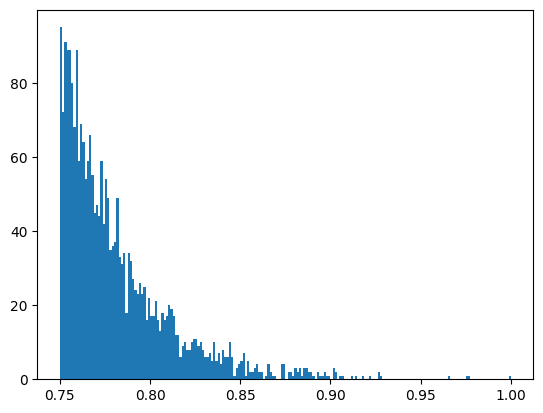

In [236]:
_ = plt.hist(hist_data, bins=200, range=(0.75,1))

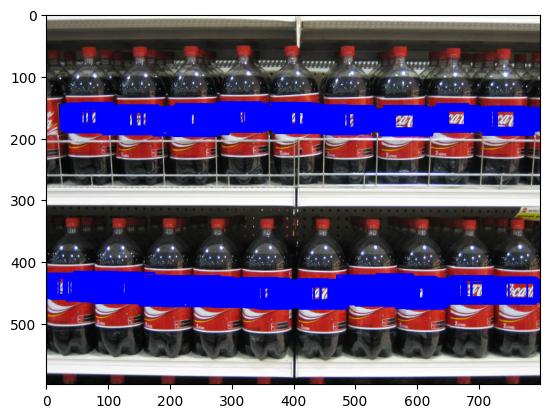

In [237]:
plt.imshow(modified_image)

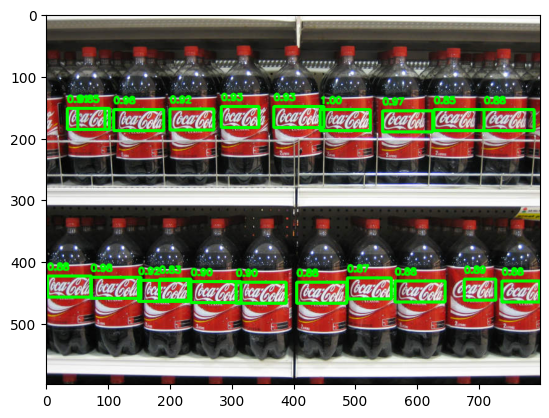

In [242]:
# Apply non-maximum suppression
coca_multi_copy = coca_multi.copy()
indices = cv.dnn.NMSBoxes(bboxes=bbox_multi, scores=scores_multi, score_threshold=0.82, nms_threshold=0.90, eta=0.99)
# Filter out the boxes based on the NMS result
filtered_boxes = [bbox_multi[i] for i in indices.flatten()]
filtered_scores = [scores_multi[i] for i in indices.flatten()]
# Draw the filtered boxes on the image
for (xmin, ymin, xmax, ymax), score in zip(filtered_boxes, filtered_scores):
    cv.rectangle(coca_multi_copy, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    text = f"{score:.2f}"
    cv.putText(
        coca_multi_copy, 
        text, 
        (xmin, ymin - 10),  # Position text slightly above the top-left corner of the box
        cv.FONT_HERSHEY_SIMPLEX, 
        0.5,  # Font size
        (0, 255, 0),  # Font color (same as the box)
        2,  # Thickness
        cv.LINE_AA
    )
plt.imshow(coca_multi_copy)